<a href="https://colab.research.google.com/github/poojakedia/TensorFlow-Course/blob/master/Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# English to Python 2

In this notebook, we build on the English to Python model by adding Attention.

## Attention

As we saw, our encoder-to-decoder model doesn't really perform all that well. Our loss is very high! Let's see if we can lower this.

Let's say someone asks you to translate a sentence from English to another language. Ask yourself, is the translation a word-by-word translation of the English sentence? Furthermore, do you translate the sentence based on every word, or based on a couple words? For example, to translate the sentence "The dog jumped over the moon", do you need to focus on every word?

It turns out, when we perform translation tasks, it isn't entirely important to us what every single word is. What matters is the context is the same for both sentences. Furthermore, one of the biggest issues with the encoder-to-decoder model is that we are trying to squish all context into one vector. As a result, the model struggles to understand what we are inputting.

Hence, we can improve this model by adding Attention.

Attention stems from the state-of-the-art paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762). This paper is arguably the most important paper right now so I highly recommend reading/skimming through it. We will talk about the Transformer Model and Self-Attention next week.

Visually, here is what attention looks like:

![img](https://jalammar.github.io/images/t/transformer_self-attention_visualization.png)

In the visual, you can see that when the model looks to identify what "it" refers to, the model focuses its "attention" onto the input words with different "strengths of attention" on each word. For example, you can see the word "animal" highlighted in dark orange whereas the word "tire" is highlighted in a very light shade of orange.

### How Does Attention Work?
Earlier, I said that each word has a different strength of attention. The way this works can be illustrated in the below image:

![img alt](https://miro.medium.com/v2/resize:fit:1040/1*WfgLRzrwiGacqPaJqGYgag.png)

Recall that in the encoder model, we not only got the final hidden state output (the context vector, which we passed to the decoder as the initial hidden state), but we also got an output at each time step. Each output represents a encoded vector of the word at the time step. Instead of just passing the context vector to the decoder, we can also have the decoder take in the encoded vectors. For each encoded vector, we can concate (or add/average) it with the last hidden state in the decoder, s_i-1. Then, we pass this vector into an artificial neural network (ANN) with 1 output. This output would be e_ij, as shown in the above image. Now, at this point, each timestep would have a score e_ij, where i = time step of encoder and j = time step of decoder. We can then apply a softmax on this vector of scores to get a score between 0 and 1 for each timestep i. We can call the new score a_ij, as shown in the above image. Now each encoded vector i has a corresponding attention weight a_ij. We can now combine these weights and vectors into a single context vector c_i by taking a weighted summation as shown in the image above. At this point, we now have our context vector which we can input into the model. However, we also need the model to take in the the last output as input so that the model can understand what it generated last. You can average the values of both vectors (feel free to experiment with this!)

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchtext
from torchtext.data import get_tokenizer
import tokenize
import io
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.stem import PorterStemmer

# Setting the device for model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [ ]:
# Retrieving the data
!wget "https://drive.google.com/u/0/uc?id=1rHb0FQ5z5ZpaY2HpyFGY6CeyDG0kTLoO&export=download" -O english_python_data.txt

--2023-11-13 00:16:37--  https://drive.google.com/u/0/uc?id=1rHb0FQ5z5ZpaY2HpyFGY6CeyDG0kTLoO&export=download
Resolving drive.google.com (drive.google.com)... 108.177.112.101, 108.177.112.100, 108.177.112.102, ...
Connecting to drive.google.com (drive.google.com)|108.177.112.101|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1rHb0FQ5z5ZpaY2HpyFGY6CeyDG0kTLoO&export=download [following]
--2023-11-13 00:16:37--  https://drive.google.com/uc?id=1rHb0FQ5z5ZpaY2HpyFGY6CeyDG0kTLoO&export=download
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-3o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/k3pb3bul09682g2prsmb51kbo2ng9tcf/1699834575000/02008525212197398114/*/1rHb0FQ5z5ZpaY2HpyFGY6CeyDG0kTLoO?e=download&uuid=c5b348d0-3a5c-4faa-aed4-e2052241c345 [following]
--2023-11-13 00:16:38--  https://doc-14-3o-docs.googleuserconten

In [ ]:
# Examining the dataset
with open('english_python_data.txt',"r") as data_file:
  print(data_file.readlines()[:5]) # Printing out the first 5 lines of the data

['# write a python program to add two numbers \n', 'num1 = 1.5\n', 'num2 = 6.3\n', 'sum = num1 + num2\n', "print(f'Sum: {sum}')\n"]


In [ ]:
# Making a dataset
with open('english_python_data.txt',"r") as data_file:
  data_lines = data_file.readlines()
  dps = [] # List of dictionaries
  dp = None # The current problem and solution
  for line in data_lines:
    if line[0] == "#":
      if dp:
        dp['solution'] = ''.join(dp['solution'])
        dps.append(dp)
      dp = {"question": None, "solution": []}
      dp['question'] = line[1:]
    else:
      dp["solution"].append(line)

# converting the data to a table for easier viewing
dataset = pd.DataFrame(dps)
dataset

,question,solution
0,write a python program to add two numbers \n,num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...
1,write a python function to add two user provi...,"def add_two_numbers(num1, num2):\n sum = nu..."
2,write a program to find and print the largest...,\nnum1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >=...
3,write a program to find and print the smalles...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <= n...
4,Write a python function to merge two given li...,"def merge_lists(l1, l2):\n return l1 + l2\n..."
...,...,...
4952,Write a program to print bit wise AND of two ...,a = 60 # 60 = 0011 1100\nb = 13 ...
4953,Write a program to print bit wise OR of two n...,"a = 60\nb = 13\n\nc = a | b\nprint(""OR"", c)\n\n\n"
4954,Write a program to print bit wise XOR of two ...,"a = 60\nb = 13\n\nc = a ^ b\nprint(""XOR"", c)\n..."
4955,Write a program to calculate Binary Ones Comp...,"a = 60\n\nc = ~a\nprint(""Binary Ones Complemen..."


In [ ]:
# Looking at the first question and the corresponding solution
print(dataset.loc[0,'question'])
print(dataset.loc[0,'solution'])

 write a python program to add two numbers 

num1 = 1.5
num2 = 6.3
sum = num1 + num2
print(f'Sum: {sum}')





In [ ]:
# Creating a class that holds the vocabulary mappings for each
# "Language" (English and Python in our case)

# Setting the SOS and EOS tokens
SOS_token = 1
EOS_token = 2

class Language:
  def __init__(self,name):
    self.name = name
    self.word2index = {'SOS':1,'EOS':2}
    self.word2count = {}
    self.index2word = {1:'SOS',2:'EOS'}
    self.n_words = 3

  # method to add sentences
  def addSentence(self, sentence):
    for word in sentence:
      self.addWord(word)

  # Method to add a word
  def addWord(self,word):
    if word not in self.word2index.keys():
      self.word2index[word] = self.n_words
      self.word2count[word] = 1
      self.index2word[self.n_words] = word
      self.n_words += 1
    else:
      self.word2count[word] += 1

In [ ]:
# Preprocessing the Python Code
# For this one, I just need to tokenize the Python code
indicies_to_ignore = [] # indicies that have broken Python code
tokenized_python = []
for i in range(dataset.shape[0]):
  try:
    solution = dataset.loc[i,'solution'].strip("\n ") # Stripping \n
    tokenized_code = [token.string for token in list(tokenize.generate_tokens(io.StringIO(solution).readline)) if token.string] # also removing empty characters
    tokenized_python.append(tokenized_code)
  except:
    indicies_to_ignore.append(i)
print(f'Total Acceptable Examples: {len(tokenized_python)}')

Total Acceptable Examples: 4928


In [ ]:
# Dropping the indicies that were in the indicies_to_ignore list.
# Python code was written properly for me to utilize that example.
dataset_copy = dataset.copy()
dataset_copy.drop(indicies_to_ignore,inplace=True)
dataset_copy.reset_index(drop=True, inplace=True)
dataset_copy

,question,solution
0,write a python program to add two numbers \n,num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...
1,write a python function to add two user provi...,"def add_two_numbers(num1, num2):\n sum = nu..."
2,write a program to find and print the largest...,\nnum1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >=...
3,write a program to find and print the smalles...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <= n...
4,Write a python function to merge two given li...,"def merge_lists(l1, l2):\n return l1 + l2\n..."
...,...,...
4923,Write a program to print bit wise AND of two ...,a = 60 # 60 = 0011 1100\nb = 13 ...
4924,Write a program to print bit wise OR of two n...,"a = 60\nb = 13\n\nc = a | b\nprint(""OR"", c)\n\n\n"
4925,Write a program to print bit wise XOR of two ...,"a = 60\nb = 13\n\nc = a ^ b\nprint(""XOR"", c)\n..."
4926,Write a program to calculate Binary Ones Comp...,"a = 60\n\nc = ~a\nprint(""Binary Ones Complemen..."


In [ ]:
# Cleaning the English texts
cleaned_english = []
url_pattern = re.compile(r"https?://\S+")
tokenizer = get_tokenizer('basic_english')
stemmer = PorterStemmer()

for i in range(dataset_copy.shape[0]):
  sentence = dataset_copy.loc[i,'question']
  sentence = sentence.lower() # lowercasing everything
  sentence = sentence.strip("\n") # removing \n
  sentence = url_pattern.sub('',sentence) # Replacing any urls
  sentence = re.sub(r"([.!?])","",sentence) # removing any punctuation
  sentence = re.sub(r'^\d+ ',"",sentence)
  sentence = tokenizer(sentence) # tokenizing
  sentence = [stemmer.stem(word) for word in sentence] # Stemming
  cleaned_english.append(sentence)

print(f'Number of Sentences: {len(cleaned_english)}')

Number of Sentences: 4928


In [ ]:
# Zipping everything together to get a complete dataset
prepared_data = list(zip(cleaned_english,tokenized_python))

In [ ]:
# Building the 2 vocabularies
english_lang = Language('english')
python_lang = Language('python')

# Populating the vocabularies
for (english, python) in prepared_data:
  english_lang.addSentence(english)
  python_lang.addSentence(python)

In [ ]:
# Printing the number of words in each vocabulary
print(f'Number of words in the English Vocabulary: {english_lang.n_words}')
print(f'Number of words in the Python Vocabulary: {python_lang.n_words}')

Number of words in the English Vocabulary: 1987
Number of words in the Python Vocabulary: 6873


In [ ]:
# Getting the maximum length for both sequences
max_length_eng = 0
max_length_python = 0
avg_eng_length = 0
avg_python_length = 0
number_of_pairs = 0

for (english,python) in prepared_data:
  if len(english) > max_length_eng:
    max_length_eng = len(english)

  if len(python) > max_length_python:
    max_length_python = len(python)

  number_of_pairs += 1
  avg_eng_length += len(english)
  avg_python_length += len(python)

# Printing out the maximum lengths
print(f'Maximum Length of an English Sentence: {max_length_eng}')
print(f'Maximum Length of Python code: {max_length_python}')

# Printing out the average lengths
print(f'Average Length of an English Sentence: {avg_eng_length / number_of_pairs}')
print(f'Average Length of Python code: {avg_python_length / number_of_pairs}')

Maximum Length of an English Sentence: 71
Maximum Length of Python code: 750
Average Length of an English Sentence: 12.633928571428571
Average Length of Python code: 44.77617694805195


In [ ]:
# Creating the dataset
final_prepared_data = []
for (english,python) in prepared_data:
  english_sentence = ['SOS']
  english_sentence.extend(english)
  english_sentence.append('EOS')

  python_sentence = ['SOS']
  python_sentence.extend(python)
  python_sentence.append('EOS')

  # Tokenizing the english sentences
  tokenized_english = []
  for word in english_sentence:
    tokenized_english.append(english_lang.word2index[word])

  # Tokenizing the python sentences
  tokenized_python = []
  for word in python_sentence:
    tokenized_python.append(python_lang.word2index[word])

  # Getting the padding needed
  """

  You might want to play around with the max length!


  """
  padding_needed_eng = 21 - len(tokenized_english)
  padding_needed_python = 51 - len(tokenized_python)

  # Checking if I need to trim
  if padding_needed_eng <= 0:
    tokenized_english = tokenized_english[:20]
    tokenized_english.append(EOS_token)
    tokenized_english = torch.from_numpy(np.array(tokenized_english))
  else:
    tokenized_english = nn.functional.pad(torch.from_numpy(np.array(tokenized_english)),(0,padding_needed_eng))

  # Checking if I need to trim for Python
  if padding_needed_python <= 0:
    tokenized_python = tokenized_python[:50]
    tokenized_python.append(EOS_token)
    tokenized_python = torch.from_numpy(np.array(tokenized_python))
  else:
    tokenized_python = nn.functional.pad(torch.from_numpy(np.array(tokenized_python)),(0,padding_needed_python))

  final_prepared_data.append((tokenized_english.numpy(),tokenized_python.numpy()))

In [ ]:
# Splitting the data into training, testing, and validation
training, testing = train_test_split(final_prepared_data,test_size=0.2,random_state=42,shuffle=True)

# Splitting the data into inputs and outputs
inputs_train = torch.Tensor([pair[0] for pair in training])
outputs_train = torch.Tensor([pair[1] for pair in training])
inputs_test = torch.Tensor([pair[0] for pair in testing])
outputs_test = torch.Tensor([pair[1] for pair in testing])

# Creating the Tensor Datasets
training_dataset = TensorDataset(inputs_train,outputs_train)
testing_dataset = TensorDataset(inputs_test,outputs_test)

# Building the data loaders
training_dataloader = DataLoader(training_dataset,batch_size=32,shuffle=True)
testing_dataloader = DataLoader(testing_dataset,batch_size=32,shuffle=True)

<ipython-input-15-4ed79e77974d>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  inputs_train = torch.Tensor([pair[0] for pair in training])


In [ ]:
 # Building the Encoder
class Encoder(nn.Module):
  def __init__(self,input_size=english_lang.n_words,hidden_size=30,dropout_p=0.2):
    super().__init__()
    self.hidden_size = hidden_size

    """

    This is the encoder, this is where you will build a custom encoder!

    """
    self.embedding = nn.Embedding(input_size,hidden_size)
    self.gru = nn.GRU(hidden_size,hidden_size,batch_first=True)
    self.dropout = nn.Dropout(dropout_p)

  def forward(self,inputs):
    embedded = self.dropout(self.embedding(inputs))
    outputs, hiddens = self.gru(embedded)
    return outputs, hiddens

In [ ]:
# Building the Decoder
class Decoder(nn.Module):
  def __init__(self,hidden_size=30,output_size=python_lang.n_words):
    super().__init__()
    """

    This is the decoder, this is where you build a custom decoder!


    """
    self.embedding = nn.Embedding(output_size,hidden_size)
    self.gru = nn.GRU(hidden_size,hidden_size,batch_first=True)
    self.out = nn.Linear(hidden_size,output_size)

    # ANN for attention
    self.attent1 = nn.Linear(hidden_size * 2,50)
    self.attention_out = nn.Linear(50,1)

  def forward(self,encoder_outputs, encoder_hidden, target_tensor=None):
    batch_size = encoder_outputs.size(0)
    decoder_input = torch.empty(batch_size,1,dtype=torch.long,device=device).fill_(SOS_token)
    decoder_hidden = encoder_hidden.squeeze(dim=0)
    decoder_hidden = decoder_hidden.unsqueeze(dim=1)
    decoder_outputs = []

    for i in range(51):
      # Calculating the attention weights
      concatenated_vector = torch.cat([decoder_hidden.expand(-1,21,-1),encoder_outputs],dim=2)
      attention_weights = nn.functional.softmax(self.attention_out(nn.functional.tanh(self.attent1(concatenated_vector))),dim=1)
      attention_weights = torch.reshape(attention_weights,(-1,1,21))
      context_vector = torch.bmm(attention_weights,encoder_outputs)

      # Sending the decoder input through the embedding
      decoder_input = self.embedding(decoder_input)
      decoder_input = decoder_input + context_vector
      decoder_output, decoder_hidden = self.forward_step(decoder_input,decoder_hidden)
      decoder_outputs.append(decoder_output)

      if target_tensor is not None:
        decoder_input = target_tensor[:,i].unsqueeze(1)
      else:
        # Making predictions
        _, topi = nn.functional.softmax(decoder_output,dim=1).topk(1)
        decoder_input = topi.squeeze(-1).detach()

    decoder_outputs = torch.cat(decoder_outputs, dim=1)
    return decoder_outputs, decoder_hidden

  def forward_step(self,inputs,hidden):
    batch_size = hidden.size(0)
    output, hidden = self.gru(inputs,torch.reshape(hidden,(1,batch_size,-1)))
    output = self.out(output)
    return output, torch.reshape(hidden,(batch_size,1,-1))

In [ ]:
# Defining the model
"""

This is where we define the model,
you may also need to tune this part
as well!

"""
encoder = Encoder(hidden_size=200)
decoder = Decoder(hidden_size=200)
encoder.to(device)
decoder.to(device)

# Defining model metrics
loss_fn = nn.CrossEntropyLoss(reduction='sum')

"""


You may need to play with the optimizer and the learning rate.


"""
encoder_optim = optim.Adam(encoder.parameters(),lr=0.001)
decoder_optim = optim.Adam(decoder.parameters(),lr=0.001)

In [ ]:
# Defining a function for training on each epoch
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer,loss_fn, dataset):
  # Setting the model to training model
  encoder.train()
  decoder.train()

  total_loss = 0
  for X, y in dataloader:
    X = X.to(device)
    y = y.to(device)

    encoder_outputs, encoder_hidden = encoder(X.int())
    decoder_outputs, _ = decoder(encoder_outputs, encoder_hidden)

    # One-hot-encoding y
    y = nn.functional.one_hot(y.to(torch.int64),num_classes=python_lang.n_words)

    loss = loss_fn(decoder_outputs.float(),y.float())
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    total_loss += loss
  return total_loss / len(dataset)

In [ ]:
# Training the model
training_losses = []
epochs = 150 # You may need to change the number of epochs!!!

for epoch in range(epochs):
  loss = train_epoch(training_dataloader,encoder,decoder,encoder_optim,decoder_optim,loss_fn,training_dataset)
  training_losses.append(loss.item())
  print(f'Epoch {epoch}')
  print(loss.item())
  print()

Epoch 0
184.5426788330078

Epoch 1
178.2742156982422

Epoch 2
174.96620178222656

Epoch 3
172.2029571533203

Epoch 4
169.81622314453125

Epoch 5
167.8396453857422

Epoch 6
165.69589233398438

Epoch 7
164.05767822265625

Epoch 8
162.61427307128906

Epoch 9
160.84939575195312

Epoch 10
159.71839904785156

Epoch 11
158.4272918701172

Epoch 12
157.3994140625

Epoch 13
156.3924560546875

Epoch 14
155.49966430664062

Epoch 15
154.81744384765625

Epoch 16
153.95559692382812

Epoch 17
153.12265014648438

Epoch 18
152.0305633544922

Epoch 19
151.28334045410156

Epoch 20
150.6188507080078

Epoch 21
149.94309997558594

Epoch 22
149.2940673828125

Epoch 23
148.4418487548828

Epoch 24
147.79331970214844

Epoch 25
147.15420532226562

Epoch 26
146.39035034179688

Epoch 27
146.0203094482422

Epoch 28
145.43524169921875

Epoch 29
144.9259490966797

Epoch 30
144.90322875976562

Epoch 31
144.33078002929688

Epoch 32
143.41123962402344

Epoch 33
142.6684112548828

Epoch 34
142.04063415527344

Epoch 35
141

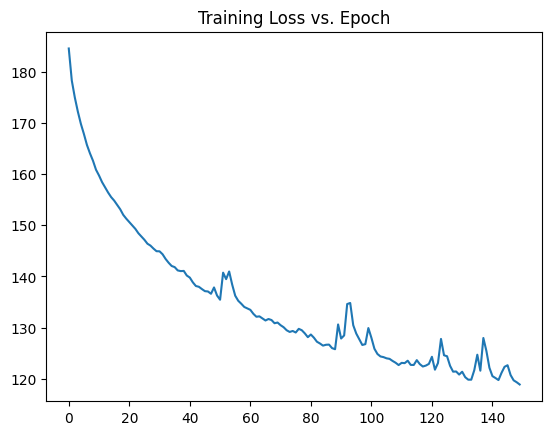

In [ ]:
# Ensure that the loss is decreasing and model is training correctly
plt.title('Training Loss vs. Epoch')
plt.plot(training_losses)
plt.show()

In [ ]:
# Getting the loss on the training set
encoder.eval()
decoder.eval()

total = 0
for X, y in training_dataloader:
  X = X.to(device)
  y = y.to(device)

  encoder_outputs, encoder_hidden = encoder(X.int())
  decoder_outputs, _ = decoder(encoder_outputs, encoder_hidden)
  y_encoded = nn.functional.one_hot(y.to(torch.int64),num_classes=python_lang.n_words)
  loss = loss_fn(decoder_outputs.float(),y_encoded.float()).item()
  total += loss
print(total / len(training_dataset))

114.147477210445


In [ ]:
# Getting the loss on the testing set
encoder.eval()
decoder.eval()

total = 0
for X, y in testing_dataloader:
  X = X.to(device)
  y = y.to(device)

  encoder_outputs, encoder_hidden = encoder(X.int())
  decoder_outputs, _ = decoder(encoder_outputs, encoder_hidden)
  y_encoded = nn.functional.one_hot(y.to(torch.int64),num_classes=python_lang.n_words)
  loss = loss_fn(decoder_outputs.float(),y_encoded.float()).item()
  total += loss
print(total / len(testing_dataset))

182.0166926819219


In [ ]:
# Generating Python Code
sentence = input('Input: ')

# Cleaning the input
sentence = sentence.lower() # lowercasing everything
sentence = url_pattern.sub('',sentence) # Replacing any urls
sentence = re.sub(r"([.!?])","",sentence) # removing any punctuation
sentence = tokenizer(sentence) # tokenizing
sentence = [stemmer.stem(word) for word in sentence] # Stemming

# Converting sentence into input
prepared_sentence = ['SOS']
prepared_sentence.extend(sentence)
prepared_sentence.append('EOS')
for i in range(len(prepared_sentence)):
    prepared_sentence[i] = english_lang.word2index[prepared_sentence[i]]

# Adding the padding
padding = 21 - len(prepared_sentence)

# Checking if I need to trim
if padding <= 0:
  prepared_sentence = prepared_sentence[:20]
  prepared_sentence.append(EOS_token)
  prepared_sentence = torch.from_numpy(np.array(prepared_sentence))
else:
  prepared_sentence = nn.functional.pad(torch.from_numpy(np.array(prepared_sentence)),(0,padding))


# Setting the models to evaluation mode
encoder.eval()
decoder.eval()

# Running through the model
encoder_outputs, encoder_hidden = encoder(torch.from_numpy(np.array(prepared_sentence)).int().to(device))
decoder_outputs, _ = decoder(encoder_outputs.unsqueeze(0), encoder_hidden.unsqueeze(0))

# Translating the decoder to actual code
prediction = np.argmax(nn.functional.softmax(decoder_outputs.squeeze(0),dim=1).cpu().detach().numpy(),axis=1)
prediction_converted = []
for i in range(len(prediction)):
  if prediction[i] != 0:
    prediction_converted.append(python_lang.index2word[prediction[i]])
  else:
    prediction_converted.append('<PAD>')

# Printing out the prediction
print(' '.join(prediction_converted))

Input: write a python program to add two numbers
"Demo of lt and eq in class" prior_list compute_gcd 102 "key1" casefold casefold "AEIOUaeiou" casefold casefold casefold casefold casefold "' is" "' is" else 1.8 1964 "_" "age" 'The value of x after swapping: {}' "The total terms are:" "The total terms are:" "is not an Armstrong number" ":" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply" "3.Multiply"
